# Improve CAM implementation

Start with PNAS version:

```
inputs: [QBP, TBP, VBP, PS, SOLIN, SHFLX, LHFLX]
outputs: [PHQ, TPHYSTND, FSNT, FSNS, FLNT, FLNS, PRECT]
```

Changes to make in NN subroutines
- init_keras_norm() same name but different read format probably
- init_keras_matrices() change name, make dynamic?
- no more IFDEF DEEP
- cloudbrain rename

ATTENTION:
- units of T and Q output


TO COMPILE:
```
module unload intel
module load intel/17.0.4
```

## Old moisture and energy fixes

```
#ifdef MOISTUREFIX
  
  !!!!! PART 1: MOISTURE FIX !!!!!!!
  do i=1,ncol
    ! Step 0: Set negative tendencies to 0
    !ptend(c)%q(i,k,1) = max(ptend(c)%q(i,k,1), -1.*QBP(c,i,k)/ztodt)

    ! Step 1: Convert to energy stuff
    do k=1,pver
      idq(k) = ptend(c)%q(i,k,1) * state(c)%pdel(i,k) * rgrav
    end do

    ! Step 2: Vertically integrate normal and absolute
    vdq = 0.
    avdq = 0.
    do k=1,pver
      vdq = vdq + idq(k)
      avdq = avdq + abs(idq(k))
    end do

    ! Step 3: Get the total moisture error
    errq(i,c) = vdq - lhf(i, c)/latvap + NNPRECT(i, c)*1e3
    abstot = avdq + abs(NNPRECT(i, c)*1e3)
#ifdef BRAINDEBUG
    if (masterproc) then
      write (555,*) 'errq = ', errq(i,c)
      write (555,*) 'avdq = ', avdq
      write (555,*) 'abs precl = ', abs(NNPRECT(i, c)*1e3)
    endif
#endif

    ! Step 4: Apply the correction term
    do k=1,pver
      corr = errq(i,c) * abs(idq(k)) / abstot
      ptend(c)%q(i,k,1) = ptend(c)%q(i,k,1) - corr / state(c)%pdel(i,k) * gravit
    end do
    corr = errq(i,c) * abs(NNPRECT(i,c)*1e3) / abstot
    NNPRECT(i,c) = NNPRECT(i,c) - corr/1e3
end do ! column loop
  call outfld('ERRQ',errq(:ncol,c),pcols,lchnk)
#endif

#ifdef MSEFIX
  !!!!!!!!! PART 2: MSE FIX !!!!!!!!!!!!!!!
  do i=1,ncol
    ! Step 1: Convert to energy stuff
    do k=1,pver
      idq(k) = ptend(c)%q(i,k,1) * state(c)%pdel(i,k) * rgrav * latvap
      idt(k) = ptend(c)%s(i,k) * state(c)%pdel(i,k) * rgrav
    end do

    ! Step 2: Vertically integrate normal and absolute
    vdq = 0.
    avdq = 0.
    vdt = 0.
    avdt = 0.
    do k=1,pver
      vdq = vdq + idq(k)
      avdq = avdq + abs(idq(k))
      vdt = vdt + idt(k)
      avdt = avdt + abs(idt(k))
    end do

    ! Step 3: Get the total moisture error
    drad = in_fsnt(i,c) - in_fsns(i,c) - in_flnt(i,c) + in_flns(i,c)
    absrad = abs(in_fsnt(i,c)) + abs(in_fsns(i,c)) + abs(in_flnt(i,c)) + abs(in_flns(i,c))
    errt(i,c) = vdt - shf(i,c) - drad + vdq - lhf(i,c)
    abstot = avdt + absrad
#ifdef BRAINDEBUG
    if (masterproc) then
      write (555,*) 'errt = ', errt(i,c)
      write (555,*) 'avdt = ', avdt
      write (555,*) 'absrad = ', absrad
    endif
#endif

    ! Step 4: Apply the correction term
    do k=1,pver
      corr = errt(i,c) * abs(idt(k)) / abstot
      ptend(c)%s(i,k) = ptend(c)%s(i,k) - corr / state(c)%pdel(i,k) * gravit
    end do
    corr = errt(i,c) * abs(in_fsnt(i,c)) / abstot
    in_fsnt(i,c) = in_fsnt(i,c) + corr 
    corr = errt(i,c) * abs(in_fsns(i,c)) / abstot
    in_fsns(i,c) = in_fsns(i,c) - corr
    corr = errt(i,c) * abs(in_flnt(i,c)) / abstot
    in_flnt(i,c) = in_flnt(i,c) - corr
    corr = errt(i,c) * abs(in_flns(i,c)) / abstot
    in_flns(i,c) = in_flns(i,c) + corr

  end do  ! end column loop
  call outfld('ERRT',errt(:ncol,c),pcols,lchnk)
! end MSE if
#endif
```

In [1]:
len('./keras_matrices/layer')

22

In [2]:
len('_bias.txt')

9

In [3]:
len('_kernel.txt')

11

In [4]:
len('./keras_matrices/layer1_bias.txt')

32

In [5]:
len('./keras_matrices/layer1_kernel.txt')

34

To implement a namelist switch

## Debugging

In [34]:
from cbrain.imports import *
from cbrain.data_generator import *
from cbrain.utils import *
from cbrain.normalization import *
%matplotlib inline

In [2]:
CAMDIR = '/scratch/05488/tg847872/revision_debug/'

In [3]:
cam_ds = xr.open_mfdataset(CAMDIR+ 'debug.cam2.h1.*.nc', decode_times=False, concat_dim='time')
cam_ds

<xarray.Dataset>
Dimensions:       (crm_x: 8, crm_y: 1, crm_z: 28, ilev: 31, isccp_prs: 7, isccp_prstau: 49, isccp_tau: 7, lat: 64, lev: 30, lon: 128, tbnd: 2, time: 6)
Coordinates:
  * lat           (lat) float64 -87.86 -85.1 -82.31 -79.53 ... 82.31 85.1 87.86
  * lon           (lon) float64 0.0 2.812 5.625 8.438 ... 351.6 354.4 357.2
  * crm_x         (crm_x) float64 0.0 4.0 8.0 12.0 16.0 20.0 24.0 28.0
  * crm_y         (crm_y) float64 0.0
  * crm_z         (crm_z) float64 992.6 976.3 957.5 936.2 ... 38.27 24.61 14.36
  * lev           (lev) float64 3.643 7.595 14.36 24.61 ... 957.5 976.3 992.6
  * ilev          (ilev) float64 2.255 5.032 10.16 18.56 ... 967.5 985.1 1e+03
  * isccp_prs     (isccp_prs) float64 90.0 245.0 375.0 500.0 620.0 740.0 900.0
  * isccp_tau     (isccp_tau) float64 0.15 0.8 2.45 6.5 16.2 41.5 219.5
  * isccp_prstau  (isccp_prstau) float64 90.0 90.0 90.0 ... 900.0 900.0 900.2
  * time          (time) float64 0.0 0.02083 0.04167 0.0625 0.08333 0.1042
Dimensions w

### Why did we crash?

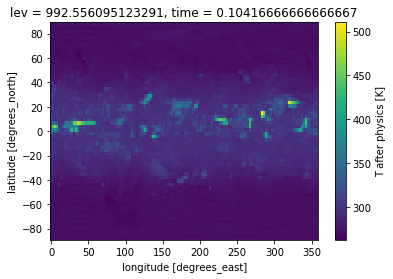

In [4]:
cam_ds.TAP.isel(time=-1, lev=29).plot()

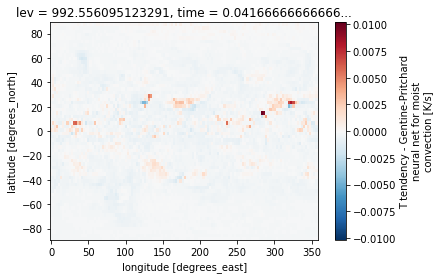

In [5]:
cam_ds.NNDT.isel(time=2, lev=29).plot()

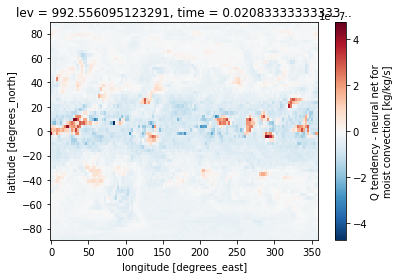

In [6]:
cam_ds.NNDQ.isel(time=1, lev=29).plot()

### Create data generator with training data

In [9]:
in_vars = ['QBP', 'TBP', 'VBP', 'PS', 'SOLIN', 'SHFLX', 'LHFLX']
out_vars = ['PHQ', 'TPHYSTND', 'FSNT', 'FSNS', 'FLNT', 'FLNS', 'PRECT']

In [31]:
scale_dict = load_pickle('../../nn_config/scale_dicts/002_pnas_scaling.pkl')

In [35]:
input_transform = InputNormalizer(
    xr.open_dataset('/home1/05488/tg847872/saved_models/001_norm.nc'),
    in_vars,
    'mean', 'std_by_var'
)

In [36]:
input_transform.sub

array([ 1.65490701e-06,  1.60977231e-06,  1.25134920e-06,  1.32252080e-06,
        1.21504206e-06,  1.13864201e-06,  1.20267748e-06,  1.27180010e-06,
        1.48661900e-06,  2.08154233e-06,  3.61759612e-06,  8.29659257e-06,
        1.91388026e-05,  4.09034001e-05,  8.28078555e-05,  1.57798175e-04,
        2.90706550e-04,  5.21253853e-04,  8.98803351e-04,  1.45990250e-03,
        2.30280589e-03,  3.48724634e-03,  4.81598545e-03,  5.64838341e-03,
        6.21533068e-03,  6.66121626e-03,  6.98323827e-03,  7.25318119e-03,
        7.44542666e-03,  7.98365194e-03,  2.41120377e+02,  2.36409531e+02,
        2.24904907e+02,  2.38087341e+02,  2.37901886e+02,  2.36464081e+02,
        2.28494003e+02,  2.25452240e+02,  2.29123871e+02,  2.35577774e+02,
        2.35431488e+02,  2.35567520e+02,  2.36163437e+02,  2.41480392e+02,
        2.43928955e+02,  2.47061829e+02,  2.50802628e+02,  2.53757736e+02,
        2.55586899e+02,  2.56965302e+02,  2.57616669e+02,  2.58223785e+02,
        2.59492523e+02,  

In [37]:
input_transform.div

array([3.77459545e-03, 3.77459545e-03, 3.77459545e-03, 3.77459545e-03,
       3.77459545e-03, 3.77459545e-03, 3.77459545e-03, 3.77459545e-03,
       3.77459545e-03, 3.77459545e-03, 3.77459545e-03, 3.77459545e-03,
       3.77459545e-03, 3.77459545e-03, 3.77459545e-03, 3.77459545e-03,
       3.77459545e-03, 3.77459545e-03, 3.77459545e-03, 3.77459545e-03,
       3.77459545e-03, 3.77459545e-03, 3.77459545e-03, 3.77459545e-03,
       3.77459545e-03, 3.77459545e-03, 3.77459545e-03, 3.77459545e-03,
       3.77459545e-03, 3.77459545e-03, 7.22105484e+01, 7.22105484e+01,
       7.22105484e+01, 7.22105484e+01, 7.22105484e+01, 7.22105484e+01,
       7.22105484e+01, 7.22105484e+01, 7.22105484e+01, 7.22105484e+01,
       7.22105484e+01, 7.22105484e+01, 7.22105484e+01, 7.22105484e+01,
       7.22105484e+01, 7.22105484e+01, 7.22105484e+01, 7.22105484e+01,
       7.22105484e+01, 7.22105484e+01, 7.22105484e+01, 7.22105484e+01,
       7.22105484e+01, 7.22105484e+01, 7.22105484e+01, 7.22105484e+01,
      

### Load the neural network

In [7]:
tf.enable_eager_execution()

In [8]:
model = tf.keras.models.load_model('/home1/05488/tg847872/saved_models/001_8col_pnas/model.h5')

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Use tf.cast instead.


### Get the input vector from cam_ds

In [10]:
in_vars

['QBP', 'TBP', 'VBP', 'PS', 'SOLIN', 'SHFLX', 'LHFLX']

In [19]:
cam_ds.NNQBP.isel(time=1, lat=0, lon=0).values

array([1.9037088e-06, 1.8891496e-06, 1.7587762e-06, 1.7570841e-06,
       1.7427531e-06, 1.6576513e-06, 1.5940370e-06, 1.5920912e-06,
       1.5923886e-06, 1.5992799e-06, 1.6422980e-06, 1.7184195e-06,
       2.1907024e-06, 4.1937187e-06, 7.7584145e-06, 1.6326150e-05,
       3.4403751e-05, 8.0006044e-05, 2.4521907e-04, 5.1732955e-04,
       8.1878394e-04, 1.1264065e-03, 1.4920642e-03, 1.9111112e-03,
       2.2697735e-03, 2.4838927e-03, 2.7039493e-03, 2.8348863e-03,
       2.8195512e-03, 2.9524004e-03], dtype=float32)

In [24]:
in_vec = np.concatenate([
    cam_ds.NNQBP.isel(time=1, lat=0, lon=0).values,
    cam_ds.NNTBP.isel(time=1, lat=0, lon=0).values,
    cam_ds.NNVBP.isel(time=1, lat=0, lon=0).values,
    cam_ds.NNPS.isel(time=1, lat=0, lon=0).values[None],
    cam_ds.NNSOLIN.isel(time=1, lat=0, lon=0).values[None],
    cam_ds.NNSHF.isel(time=1, lat=0, lon=0).values[None],
    cam_ds.NNLHF.isel(time=1, lat=0, lon=0).values[None],
])[None, :]

In [46]:
in_vec_trans = input_transform.transform(in_vec).astype(np.float32); in_vec_trans

array([[ 6.59148354e-05,  7.40151736e-05,  1.34432150e-04,
         1.15128438e-04,  1.39805969e-04,  1.37500640e-04,
         1.03682512e-04,  8.48544078e-05,  2.80214335e-05,
        -1.27765321e-04, -5.23313880e-04, -1.74274924e-03,
        -4.49004443e-03, -9.72546078e-03, -1.98827777e-02,
        -3.74800526e-02, -6.79020584e-02, -1.16899364e-01,
        -1.73153460e-01, -2.49714956e-01, -3.93160552e-01,
        -6.25455081e-01, -8.80603313e-01, -9.90112007e-01,
        -1.04529274e+00, -1.10669434e+00, -1.13370800e+00,
        -1.17053473e+00, -1.22552884e+00, -1.33292460e+00,
         7.47510195e-02, -6.25645742e-02, -1.18100569e-01,
         1.16499262e-02, -8.23573172e-02, -9.51504335e-02,
         1.29837133e-02,  4.53916490e-02, -1.97845045e-02,
        -1.22843415e-01, -1.36168391e-01, -1.72188669e-01,
        -2.06594110e-01, -3.21186304e-01, -3.70744765e-01,
        -3.97261798e-01, -3.78523707e-01, -3.23799133e-01,
        -2.29791686e-01, -1.28169894e-01, -5.10539003e-0

In [53]:
layers = model.layers; layers

In [63]:
len(layers)

16

In [56]:
x1 = layers[2](layers[1](layers[0](in_vec_trans))); x1

<tf.Tensor: id=1798, shape=(1, 256), dtype=float32, numpy=
array([[-0.0517347 , -0.17214036,  0.2873212 ,  0.5899098 , -0.11179788,
        -0.07762445,  0.09245125, -0.05878264,  0.11267984, -0.13644007,
        -0.03352039,  0.49877053,  0.03356677,  0.01682265,  1.0699519 ,
         0.03556597,  1.2698492 , -0.10997623, -0.2413041 , -0.10721651,
        -0.24758653,  0.25445515, -0.14949138,  0.12684652, -0.18662485,
         0.29498497, -0.5028035 ,  0.05865669, -0.02469519, -0.02487404,
        -1.6322104 ,  2.014826  ,  0.16435814,  0.08317649,  0.53019655,
         0.4206132 ,  2.6787024 , -0.09546193, -0.02380275,  0.44311953,
        -0.06932011,  0.18077864,  0.30292803,  0.31970716, -0.0323306 ,
        -0.19205235,  1.273994  ,  0.558271  ,  0.42686915, -0.30960757,
         0.03315544,  1.0129659 ,  0.03325522,  0.06138106,  0.66578364,
        -0.06177435, -0.09331296, -0.15778635,  0.2572639 ,  0.09818572,
        -0.37481698, -0.08678438,  0.37035626, -0.2201486 ,  0.52

In [57]:
x2 = layers[4](layers[3](x1)); x2

<tf.Tensor: id=1804, shape=(1, 256), dtype=float32, numpy=
array([[-6.35061443e-01,  4.84650195e-01, -6.46301508e-01,
        -4.78383988e-01, -4.24162410e-02, -5.94667733e-01,
        -7.47661352e-01, -2.25083724e-01,  1.04281759e+00,
        -4.69999582e-01, -3.99351604e-02,  9.35040712e-02,
        -3.44943315e-01, -2.06182301e-02, -8.90642643e-01,
        -8.85375291e-02, -7.26119757e-01,  3.01235020e-02,
         9.97765064e-02, -2.14280039e-01, -1.04561400e+00,
        -1.58332497e-01, -6.11940801e-01, -3.42659295e-01,
         8.45842361e-02,  3.03570819e+00, -2.37787798e-01,
        -2.05831435e-02, -2.86264300e-01, -5.92298627e-01,
        -2.61593294e+00, -1.50953561e-01,  1.22168159e+00,
        -6.90771818e-01, -2.79009342e-01, -9.05403674e-01,
        -2.70352721e-01, -2.16926187e-01,  1.25305915e+00,
        -1.92528993e-01, -3.04169953e-01, -1.11709967e-01,
        -1.19166143e-01, -8.27282012e-01,  2.59130388e-01,
        -1.10959411e+00, -1.64363086e-01, -1.69582114e-0

In [58]:
x3 = layers[6](layers[5](x2)); x3

<tf.Tensor: id=1810, shape=(1, 256), dtype=float32, numpy=
array([[-4.73087341e-01, -2.16987450e-02, -7.36132741e-01,
         6.16130233e-03,  9.55629349e-01, -1.79117107e+00,
         2.02501130e+00, -7.75053203e-01, -9.27132964e-01,
        -2.89757967e-01, -6.39664382e-02, -1.57560706e+00,
        -2.49650463e-01,  1.23315975e-01, -9.89571363e-02,
        -4.91822511e-01,  1.12270904e+00, -2.92919189e-01,
        -6.05560362e-01, -4.97175276e-01, -1.26813519e+00,
         2.79855728e-03, -5.07331826e-03, -2.54781693e-01,
        -4.51400876e-01, -5.23789585e-01, -1.02032730e-02,
        -1.63316095e+00,  2.22653687e-01, -5.13063312e-01,
        -5.38247943e-01, -4.35698688e-01, -6.04255557e-01,
        -2.83735067e-01,  5.36732495e-01,  2.90347368e-01,
         2.70747066e+00, -3.22290063e-01, -3.66464645e-01,
        -9.53316629e-01, -2.87753075e-01, -4.35391784e-01,
        -5.16739227e-02, -1.44620597e-01, -9.87379670e-01,
        -8.27667058e-01, -1.23497975e+00, -3.54526669e-0

In [59]:
x4 = layers[8](layers[7](x3)); x4

<tf.Tensor: id=1816, shape=(1, 256), dtype=float32, numpy=
array([[-9.2565161e-01, -8.6382169e-01, -1.8415321e+00, -1.6786431e-01,
        -2.2565152e-01,  1.7385538e+00,  8.8511968e-01, -3.2768670e-01,
        -6.2415093e-01, -8.4617591e-01,  4.2368189e-01, -7.6781422e-01,
        -6.0638469e-01, -4.1011205e-01, -3.9611098e-01,  2.2187676e+00,
        -4.2420527e-01, -6.1223954e-02, -5.4843318e-01,  3.9593339e-02,
        -4.0492693e-01, -1.6147153e+00, -9.0227324e-01, -1.5820481e-01,
        -2.9241046e-01, -1.7464772e-01, -6.4196223e-01, -3.3823204e-01,
        -1.6262931e+00, -1.0822834e+00, -1.0675619e+00, -8.8195449e-01,
        -1.7825392e-01, -5.0118250e-01,  9.2842746e-01, -4.0886313e-01,
         7.9538107e-01, -1.7287282e+00, -1.2790707e+00, -6.8281257e-01,
        -1.1355120e-01,  3.4402423e+00,  1.1254900e+00, -2.7972949e-01,
        -2.2533753e+00,  5.8741146e-01, -1.0483614e+00,  1.1113175e+00,
        -2.2766218e+00, -1.1087543e-01, -1.0144714e+00, -1.1549774e+00,
     

In [60]:
x5 = layers[10](layers[9](x4)); x5

<tf.Tensor: id=1822, shape=(1, 256), dtype=float32, numpy=
array([[ 1.611282  , -0.39172938, -0.22787093, -0.6832645 ,  0.5722647 ,
         0.5884686 , -0.12442525, -0.01788755, -0.4895018 , -0.23785985,
        -0.6218258 , -0.35681728,  0.9811526 , -0.5547385 , -0.81634134,
        -0.43096378, -0.4454633 , -0.7218249 , -0.5690709 , -0.09033327,
        -0.9275238 , -0.7407444 , -0.09276165,  0.948331  , -0.4062986 ,
        -0.3427787 , -0.6627221 , -0.60166323, -1.8756493 ,  1.1679786 ,
        -0.629622  ,  0.47882497, -0.03235495, -0.7100563 , -0.4165103 ,
        -0.40903395, -1.267423  , -0.22728826, -0.61273885,  0.11923826,
        -0.6415663 , -0.9176854 ,  1.2420008 , -1.071088  ,  0.8940691 ,
        -0.3266267 , -0.97419846, -1.0621659 ,  0.8549422 , -0.06019812,
        -0.6206608 , -0.21803786, -0.6317911 , -0.05916814, -0.28933987,
        -0.51506746, -0.61450326, -0.4598663 , -1.6718305 , -0.5217902 ,
        -0.27977586, -0.12004743, -0.47284758, -0.08825928, -0.51

In [61]:
x6 = layers[12](layers[11](x5)); x6

<tf.Tensor: id=1828, shape=(1, 256), dtype=float32, numpy=
array([[-9.50935930e-02, -1.71464473e-01, -3.33651692e-01,
        -5.66099323e-02, -2.60245502e-01, -8.16493183e-02,
        -2.96894848e-01,  6.22324347e-02, -4.27212209e-01,
        -1.59100369e-01, -1.95261374e-01, -1.07174791e-01,
        -2.92585164e-01, -2.60049582e-01, -1.60601377e-01,
         4.02183443e-01, -1.40554667e-01, -4.84054610e-02,
        -8.63630399e-02, -1.58042729e-01, -1.06895678e-01,
        -2.20558897e-01, -1.95112117e-02, -1.44616857e-01,
         2.85689354e-01, -6.31874502e-02, -1.16099574e-01,
         7.07823634e-02, -8.06542952e-03, -7.47420359e-03,
         2.47443974e-01, -2.05590859e-01, -1.58300832e-01,
        -4.33736920e-01,  2.35323399e-01,  4.20340031e-01,
        -1.61753818e-01, -3.57226133e-01,  2.03870952e-01,
        -6.50094226e-02, -2.49787405e-01,  1.37489736e-02,
         3.86016965e-02, -1.66623294e-02,  5.24686217e-01,
         1.93764925e-01, -3.47815216e-01, -4.71558422e-0

In [64]:
x7 = layers[14](layers[13](x6)); x7

<tf.Tensor: id=1839, shape=(1, 256), dtype=float32, numpy=
array([[-0.03346551, -0.0321105 , -0.06573202,  0.11263064,  0.02748455,
        -0.02591684, -0.0023659 , -0.01296547, -0.02284596, -0.00471759,
        -0.04747875, -0.00980503, -0.03010444,  0.00142284,  0.01359774,
        -0.0106375 ,  0.04033142, -0.03835925, -0.03975753, -0.0059738 ,
        -0.01520688,  0.03356584, -0.03337166, -0.01860335, -0.02496452,
        -0.00766174, -0.02554843, -0.00579812, -0.03280387, -0.0247837 ,
        -0.00744212, -0.03652439, -0.01321403, -0.05434971, -0.01083112,
        -0.01682512, -0.01362972, -0.00218525, -0.00316069, -0.04241107,
        -0.14280343, -0.06402364, -0.05582096, -0.00456217, -0.06018514,
        -0.01854103, -0.0147765 , -0.01662648,  0.0557589 , -0.05993084,
        -0.03035116, -0.00700444, -0.01120684, -0.05514407, -0.00658634,
        -0.02190159, -0.02231484, -0.03538584, -0.04748687, -0.04628718,
        -0.0874557 , -0.0265885 , -0.01757097,  0.04794926, -0.05

In [65]:
x8 = layers[15](x7); x8

<tf.Tensor: id=1844, shape=(1, 65), dtype=float32, numpy=
array([[ 4.2698252e-31,  3.9460979e-31,  1.5204006e-07,  3.9461156e-08,
        -5.9830754e-09,  7.9048910e-09,  2.2659307e-07,  5.3115912e-08,
         7.4346462e-07, -5.9936428e-07,  5.0268136e-06,  1.1608354e-05,
         3.5041710e-05,  1.6191322e-04,  4.2073429e-05,  1.5107170e-04,
         3.4427084e-04,  3.3860840e-04,  1.4713034e-05, -1.6227365e-03,
        -1.0487805e-03,  2.0122991e-03,  7.9243165e-03,  1.6841592e-02,
        -4.6822103e-03, -7.9193981e-03, -2.4720028e-02, -1.9089228e-02,
         1.5465952e-02,  9.0164952e-03, -3.2838155e-03, -3.3090431e-03,
        -3.5990775e-04, -3.0391477e-04, -2.2458555e-03, -4.9097033e-04,
        -2.7672620e-05, -2.5752513e-04, -3.5190629e-04, -4.3708697e-04,
        -3.4435559e-04, -8.7579992e-04, -6.4786337e-04, -1.2998173e-03,
        -2.4690372e-03, -3.7306324e-03, -5.7519428e-03, -8.4328502e-03,
        -8.6182961e-03, -6.8062600e-03, -4.3316521e-03, -5.7101427e-03,
      

In [66]:
model(in_vec_trans)

<tf.Tensor: id=1885, shape=(1, 65), dtype=float32, numpy=
array([[ 4.2698252e-31,  3.9460979e-31,  1.5204006e-07,  3.9461156e-08,
        -5.9830754e-09,  7.9048910e-09,  2.2659307e-07,  5.3115912e-08,
         7.4346462e-07, -5.9936428e-07,  5.0268136e-06,  1.1608354e-05,
         3.5041710e-05,  1.6191322e-04,  4.2073429e-05,  1.5107170e-04,
         3.4427084e-04,  3.3860840e-04,  1.4713034e-05, -1.6227365e-03,
        -1.0487805e-03,  2.0122991e-03,  7.9243165e-03,  1.6841592e-02,
        -4.6822103e-03, -7.9193981e-03, -2.4720028e-02, -1.9089228e-02,
         1.5465952e-02,  9.0164952e-03, -3.2838155e-03, -3.3090431e-03,
        -3.5990775e-04, -3.0391477e-04, -2.2458555e-03, -4.9097033e-04,
        -2.7672620e-05, -2.5752513e-04, -3.5190629e-04, -4.3708697e-04,
        -3.4435559e-04, -8.7579992e-04, -6.4786337e-04, -1.2998173e-03,
        -2.4690372e-03, -3.7306324e-03, -5.7519428e-03, -8.4328502e-03,
        -8.6182961e-03, -6.8062600e-03, -4.3316521e-03, -5.7101427e-03,
      